c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map:   0%|          | 0/12575 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 1586/1586 [00:00<00:00, 52465.60 examples/s]
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

trainable params: 887,811 || all params: 111,507,462 || trainable%: 0.7962


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_32148\884386470.py:99: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.788500,0.781918,0.661774,0.613539
2,0.717200,0.747102,0.676452,0.640880
3,0.772600,0.730044,0.684110,0.662237
4,0.799800,0.720633,0.694320,0.673931
5,0.669100,0.714121,0.700702,0.684082
6,0.669200,0.713380,0.700064,0.685249
7,0.695200,0.702717,0.704531,0.690938
8,0.715900,0.700236,0.704531,0.692023
9,0.686300,0.699906,0.702616,0.690427
10,0.694900,0.698633,0.701340,0.688521


Validation Results: {'eval_loss': 0.6986329555511475, 'eval_accuracy': 0.7013401403956605, 'eval_f1': 0.6885206923484507, 'eval_runtime': 1.3011, 'eval_samples_per_second': 1204.4, 'eval_steps_per_second': 75.323, 'epoch': 10.0}
Test Set Classification Report:
               precision    recall  f1-score   support

     Neutral       0.51      0.34      0.41       361
    Positive       0.76      0.77      0.76       654
    Negative       0.69      0.82      0.75       571

    accuracy                           0.69      1586
   macro avg       0.65      0.64      0.64      1586
weighted avg       0.68      0.69      0.68      1586



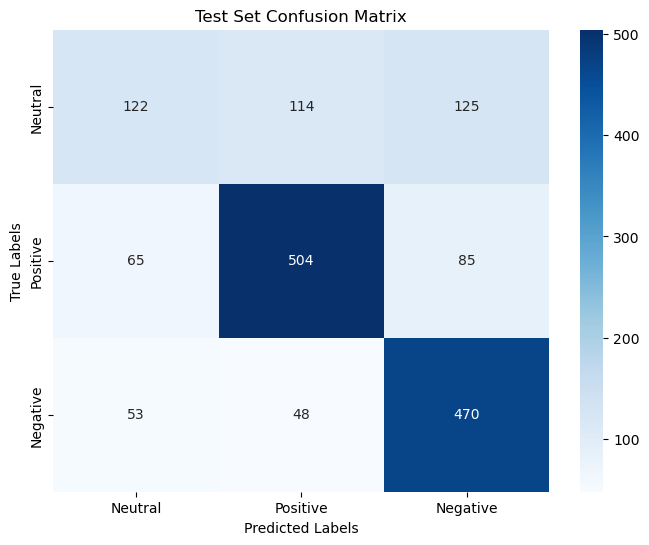

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, 
                          Trainer, TrainingArguments, EarlyStoppingCallback)

# LoRA/PEFT imports
from peft import LoraConfig, get_peft_model, TaskType

# Load datasets
train_df = pd.read_csv("data/Train.csv")
test_df = pd.read_csv("data/Test.csv")
val_df = pd.read_csv("data/Val.csv")

# Rename labels
label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
train_df["Label"] = train_df["Label"].map(label_mapping)
test_df["Label"] = test_df["Label"].map(label_mapping)
val_df["Label"] = val_df["Label"].map(label_mapping)

# Shuffle and remove missing
def preprocess_df(df):
    df.dropna(inplace=True)
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

train_df = preprocess_df(train_df)
test_df = preprocess_df(test_df)
val_df = preprocess_df(val_df)

# Convert to HF dataset
def convert_to_dataset(df):
    return Dataset.from_pandas(pd.DataFrame({'text': df['Data'], 'label': df['Label']}))

dataset = DatasetDict({
    "train": convert_to_dataset(train_df),
    "validation": convert_to_dataset(val_df),
    "test": convert_to_dataset(test_df)
})

# Label encoding
label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}
dataset = dataset.map(lambda x: {"label": [label_to_id[label] for label in x["label"]]}, batched=True)

# Load tokenizer and model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'csebuetnlp/banglabert'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Load base model
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_list))

# Define LoRA config
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],  # Adjustable depending on model internals
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

# Apply LoRA
model = get_peft_model(base_model, lora_config).to(device)
model.print_trainable_parameters()

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to=[],
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    save_total_limit=3
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train model
trainer.train()

# Evaluate on validation
val_results = trainer.evaluate()
print("Validation Results:", val_results)

# Final test eval
test_output = trainer.predict(dataset["test"])
test_predictions = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

# Classification report
report = classification_report(test_labels, test_predictions, target_names=label_list)
print("Test Set Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USERAS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USERAS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Map: 100%|██████████| 1586/1586 [00:00<00:00, 527572.86 examples/s]
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.725400,0.750125,0.673261,0.624807
2,0.764600,0.726286,0.694320,0.661692
3,0.790500,0.707848,0.699426,0.684239
4,0.838300,0.693042,0.707084,0.700758
5,0.707700,0.686954,0.706445,0.694926
6,0.697700,0.688150,0.708998,0.693808
7,0.707300,0.686490,0.711551,0.698784
8,0.665600,0.683475,0.710274,0.693941
9,0.747300,0.681968,0.708998,0.697582
10,0.752900,0.682927,0.712827,0.700547


Validation Results: {'eval_loss': 0.6819679737091064, 'eval_accuracy': 0.7089980855137205, 'eval_f1': 0.6975819613512075, 'eval_runtime': 1.1883, 'eval_samples_per_second': 1318.654, 'eval_steps_per_second': 82.468, 'epoch': 10.0}
Test Set Classification Report:
               precision    recall  f1-score   support

     Neutral       0.50      0.33      0.40       361
    Positive       0.76      0.77      0.76       654
    Negative       0.70      0.83      0.76       571

    accuracy                           0.69      1586
   macro avg       0.65      0.64      0.64      1586
weighted avg       0.68      0.69      0.68      1586



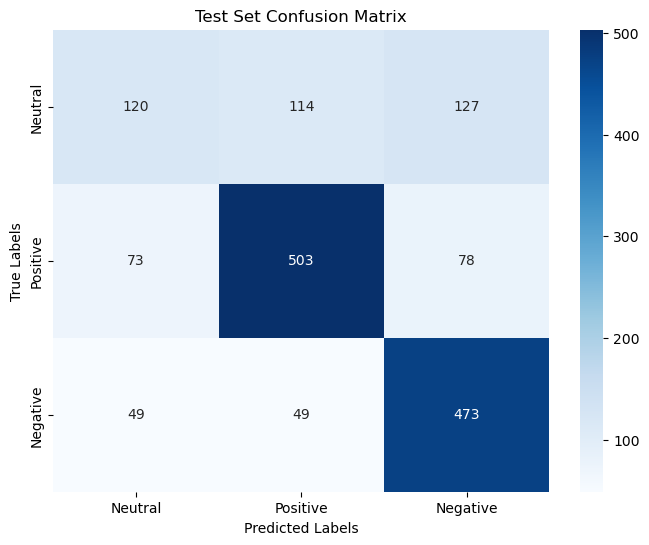

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import nltk
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback)
from peft import get_peft_model, LoraConfig, TaskType
from googletrans import Translator
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('omw-1.4')

translator = Translator()

def backtranslate_bengali(text, retries=3):
    try:
        en_text = translator.translate(text, src='bn', dest='en').text
        time.sleep(1)
        bn_text = translator.translate(en_text, src='en', dest='bn').text
        return bn_text
    except:
        if retries > 0:
            time.sleep(2)
            return backtranslate_bengali(text, retries-1)
        return text

def synonym_replace(text, n=1):
    words = text.split()
    new_words = words[:]
    random_word_list = list(set([word for word in words if len(word) > 3]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for word in random_word_list:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym_words = list(set([lemma.name() for s in synonyms for lemma in s.lemmas()]))
            synonym_words = [w for w in synonym_words if w != word and '_' not in w]
            if synonym_words:
                new_words = [w if w != word else random.choice(synonym_words) for w in new_words]
                num_replaced += 1
            if num_replaced >= n:
                break
    return ' '.join(new_words)

def augment_dataset(df, method="both", ratio=0.3):
    augmented_texts = []
    labels = []
    for idx, row in df.iterrows():
        original_text = row['Data']
        label = row['Label']
        augmented_texts.append(original_text)
        labels.append(label)
        if method in ("backtranslation", "both"):
            back_text = backtranslate_bengali(original_text)
            augmented_texts.append(back_text)
            labels.append(label)
        if method in ("eda", "both"):
            eda_text = synonym_replace(original_text)
            augmented_texts.append(eda_text)
            labels.append(label)
        if len(augmented_texts) >= len(df) * (1 + ratio * 2):
            break
    return pd.DataFrame({"Data": augmented_texts, "Label": labels})

train_df = pd.read_csv("data/Train.csv")
test_df = pd.read_csv("data/Test.csv")
val_df = pd.read_csv("data/Val.csv")

label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
train_df["Label"] = train_df["Label"].map(label_mapping)
test_df["Label"] = test_df["Label"].map(label_mapping)
val_df["Label"] = val_df["Label"].map(label_mapping)

def preprocess_df(df):
    df.dropna(inplace=True)
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

# Augment training data
augmented_train_df = augment_dataset(train_df, method="both", ratio=0.4)
train_df = preprocess_df(augmented_train_df)
test_df = preprocess_df(test_df)
val_df = preprocess_df(val_df)

def convert_to_dataset(df):
    return Dataset.from_pandas(pd.DataFrame({'text': df['Data'], 'label': df['Label']}))

dataset = DatasetDict({
    "train": convert_to_dataset(train_df),
    "validation": convert_to_dataset(val_df),
    "test": convert_to_dataset(test_df)
})

label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}

dataset = dataset.map(lambda x: {"label": [label_to_id[label] for label in x["label"]]}, batched=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'csebuetnlp/banglabert'
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_list)).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Apply LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    task_type=TaskType.SEQ_CLS,
    lora_dropout=0.05,
    bias="none"
)
model = get_peft_model(base_model, lora_config)

def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to=[],
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    save_total_limit=3
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

val_results = trainer.evaluate()
print("Validation Results:", val_results)

test_output = trainer.predict(dataset["test"])
test_predictions = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

report = classification_report(test_labels, test_predictions, target_names=label_list)
print("Test Set Classification Report:\n", report)

conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USERAS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USERAS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Map: 100%|██████████| 1586/1586 [00:00<00:00, 527656.55 examples/s]
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/17606 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is prov

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.676800,0.761525,0.668156,0.622600
2,0.777600,0.728048,0.688577,0.670740
3,0.740000,0.714814,0.699426,0.680542
4,0.696600,0.708062,0.700702,0.688080
5,0.746600,0.701897,0.708360,0.696280
6,0.686300,0.696931,0.705807,0.699709
7,0.643100,0.693387,0.708998,0.701972
8,0.705800,0.692906,0.710913,0.703464
9,0.690400,0.691370,0.711551,0.703230
10,0.650400,0.691631,0.713465,0.705021


Validation Results: {'eval_loss': 0.691369891166687, 'eval_accuracy': 0.7115507338864071, 'eval_f1': 0.7032297499376365, 'eval_runtime': 1.6073, 'eval_samples_per_second': 974.944, 'eval_steps_per_second': 60.973, 'epoch': 10.0}
Test Set Classification Report:
               precision    recall  f1-score   support

     Neutral       0.47      0.36      0.41       361
    Positive       0.77      0.74      0.76       654
    Negative       0.70      0.83      0.76       571

    accuracy                           0.69      1586
   macro avg       0.65      0.64      0.64      1586
weighted avg       0.68      0.69      0.68      1586



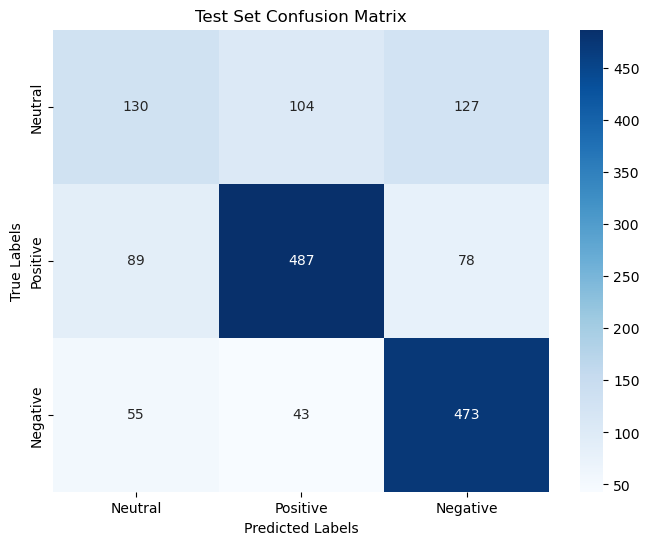

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import random
import nltk
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback)
from peft import get_peft_model, LoraConfig, TaskType
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('omw-1.4')

def synonym_replace(text, n=1):
    words = text.split()
    new_words = words[:]
    random_word_list = list(set([word for word in words if len(word) > 3]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for word in random_word_list:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym_words = list(set([lemma.name() for s in synonyms for lemma in s.lemmas()]))
            synonym_words = [w for w in synonym_words if w != word and '_' not in w]
            if synonym_words:
                new_words = [w if w != word else random.choice(synonym_words) for w in new_words]
                num_replaced += 1
            if num_replaced >= n:
                break
    return ' '.join(new_words)

def augment_dataset(df, method="eda", ratio=0.3):
    augmented_texts = []
    labels = []
    for idx, row in df.iterrows():
        original_text = row['Data']
        label = row['Label']
        augmented_texts.append(original_text)
        labels.append(label)
        if method == "eda":
            eda_text = synonym_replace(original_text)
            augmented_texts.append(eda_text)
            labels.append(label)
        if len(augmented_texts) >= len(df) * (1 + ratio):
            break
    return pd.DataFrame({"Data": augmented_texts, "Label": labels})

# Load and map labels
train_df = pd.read_csv("data/Train.csv")
test_df = pd.read_csv("data/Test.csv")
val_df = pd.read_csv("data/Val.csv")

label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
train_df["Label"] = train_df["Label"].map(label_mapping)
test_df["Label"] = test_df["Label"].map(label_mapping)
val_df["Label"] = val_df["Label"].map(label_mapping)

def preprocess_df(df):
    df.dropna(inplace=True)
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

# Augment training data
augmented_train_df = augment_dataset(train_df, method="eda", ratio=0.4)
train_df = preprocess_df(augmented_train_df)
test_df = preprocess_df(test_df)
val_df = preprocess_df(val_df)

def convert_to_dataset(df):
    return Dataset.from_pandas(pd.DataFrame({'text': df['Data'], 'label': df['Label']}))

dataset = DatasetDict({
    "train": convert_to_dataset(train_df),
    "validation": convert_to_dataset(val_df),
    "test": convert_to_dataset(test_df)
})

label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}
dataset = dataset.map(lambda x: {"label": [label_to_id[label] for label in x["label"]]}, batched=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'csebuetnlp/banglabert'
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_list)).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Apply LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    task_type=TaskType.SEQ_CLS,
    lora_dropout=0.05,
    bias="none"
)
model = get_peft_model(base_model, lora_config)

def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Training with early stopping
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to=[],
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    save_total_limit=3
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

# Evaluate on validation and test
val_results = trainer.evaluate()
print("Validation Results:", val_results)

test_output = trainer.predict(dataset["test"])
test_predictions = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

report = classification_report(test_labels, test_predictions, target_names=label_list)
print("Test Set Classification Report:\n", report)

conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USERAS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USERAS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Map: 100%|██████████| 1586/1586 [00:00<00:00, 709640.08 examples/s]
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/17606 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is prov


Training with ADAMW optimizer


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.679000,0.765884,0.666241,0.618881
2,0.773900,0.728696,0.687939,0.671801
3,0.735800,0.713747,0.696235,0.677526
4,0.696700,0.706079,0.701978,0.690083
5,0.734000,0.695741,0.714742,0.703405
6,0.680100,0.690833,0.714742,0.711229
7,0.621500,0.687761,0.714103,0.705211
8,0.699600,0.683522,0.721123,0.716572
9,0.667300,0.679039,0.724314,0.719036
10,0.609200,0.685256,0.720485,0.712940


Validation Results (ADAMW): {'eval_loss': 0.6743801236152649, 'eval_accuracy': 0.7262284620293554, 'eval_f1': 0.7200526802090003, 'eval_runtime': 1.7447, 'eval_samples_per_second': 898.167, 'eval_steps_per_second': 56.171, 'epoch': 19.0}
Test Set Classification Report (ADAMW):
               precision    recall  f1-score   support

     Neutral       0.51      0.41      0.45       361
    Positive       0.77      0.76      0.77       654
    Negative       0.72      0.82      0.77       571

    accuracy                           0.70      1586
   macro avg       0.67      0.66      0.66      1586
weighted avg       0.69      0.70      0.70      1586



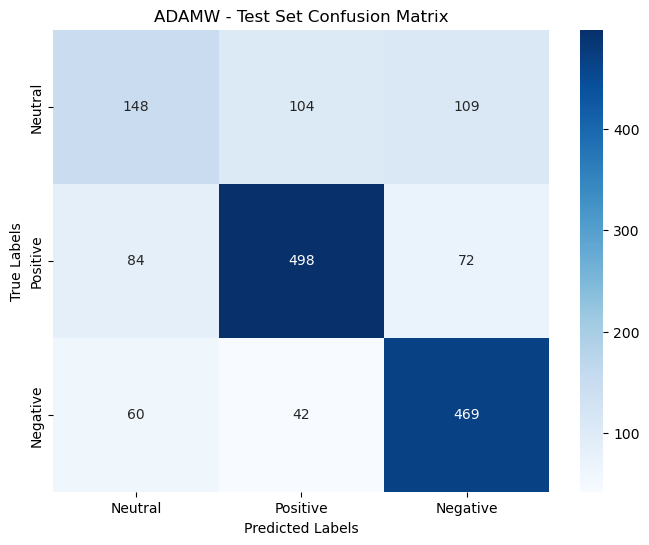


Training with LION optimizer


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\4202039296.py:142: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.544600,0.682882,0.714103,0.701084
2,0.567300,0.703497,0.722399,0.714925
3,0.564000,0.704811,0.719209,0.702934
4,0.459700,0.742979,0.717294,0.711735


Validation Results (LION): {'eval_loss': 0.6828815937042236, 'eval_accuracy': 0.7141033822590938, 'eval_f1': 0.7010835360764059, 'eval_runtime': 1.4159, 'eval_samples_per_second': 1106.74, 'eval_steps_per_second': 69.215, 'epoch': 4.0}
Test Set Classification Report (LION):
               precision    recall  f1-score   support

     Neutral       0.50      0.33      0.40       361
    Positive       0.74      0.80      0.77       654
    Negative       0.73      0.83      0.77       571

    accuracy                           0.70      1586
   macro avg       0.66      0.65      0.65      1586
weighted avg       0.68      0.70      0.69      1586



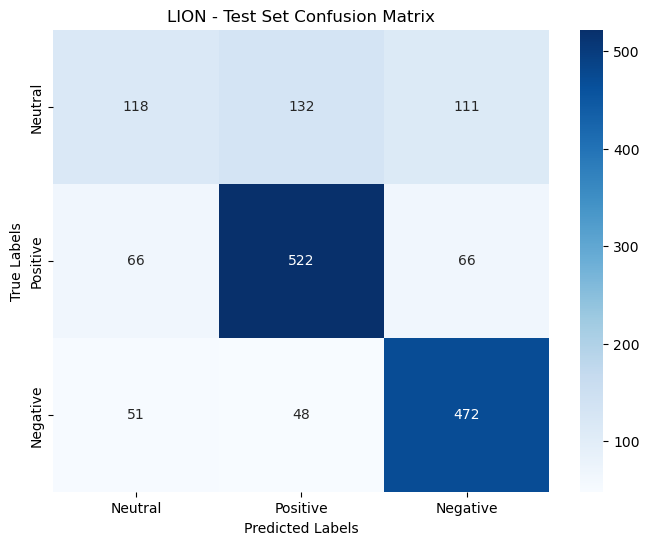


Training with ADAFACTOR optimizer


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\4202039296.py:142: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.509400,0.724380,0.716656,0.706865
2,0.563200,0.703703,0.716656,0.709337
3,0.580800,0.699707,0.712827,0.701855
4,0.495300,0.693741,0.716656,0.711433
5,0.496700,0.710075,0.718571,0.705540
6,0.531000,0.711502,0.717932,0.711865
7,0.429400,0.719437,0.728143,0.718512


Validation Results (ADAFACTOR): {'eval_loss': 0.693740725517273, 'eval_accuracy': 0.7166560306317805, 'eval_f1': 0.7114333669780588, 'eval_runtime': 1.5043, 'eval_samples_per_second': 1041.696, 'eval_steps_per_second': 65.148, 'epoch': 7.0}
Test Set Classification Report (ADAFACTOR):
               precision    recall  f1-score   support

     Neutral       0.52      0.43      0.47       361
    Positive       0.79      0.75      0.77       654
    Negative       0.73      0.85      0.78       571

    accuracy                           0.71      1586
   macro avg       0.68      0.68      0.68      1586
weighted avg       0.71      0.71      0.71      1586



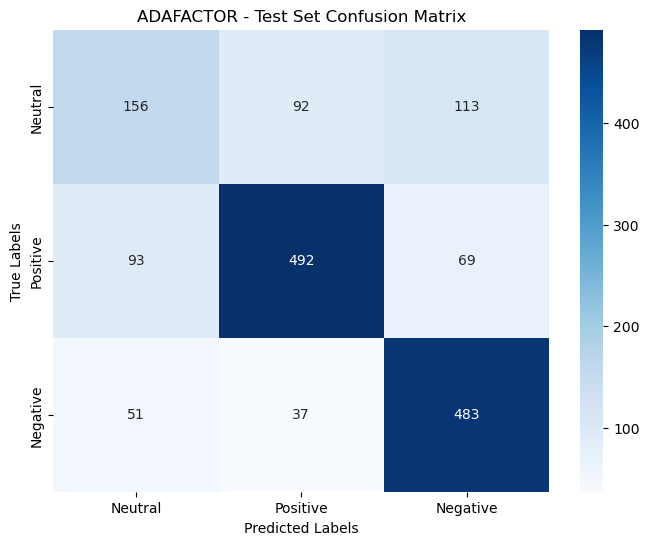

In [7]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import random
import nltk
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,
                          EarlyStoppingCallback, AdamW, Adafactor)
from peft import get_peft_model, LoraConfig, TaskType
from nltk.corpus import wordnet
from lion_pytorch import Lion

nltk.download('wordnet')
nltk.download('omw-1.4')

# Synonym Replacement for EDA
def synonym_replace(text, n=1):
    words = text.split()
    new_words = words[:]
    random_word_list = list(set([word for word in words if len(word) > 3]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for word in random_word_list:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym_words = list(set([lemma.name() for s in synonyms for lemma in s.lemmas()]))
            synonym_words = [w for w in synonym_words if w != word and '_' not in w]
            if synonym_words:
                new_words = [w if w != word else random.choice(synonym_words) for w in new_words]
                num_replaced += 1
            if num_replaced >= n:
                break
    return ' '.join(new_words)

# Augmentation
def augment_dataset(df, method="eda", ratio=0.3):
    augmented_texts = []
    labels = []
    for idx, row in df.iterrows():
        original_text = row['Data']
        label = row['Label']
        augmented_texts.append(original_text)
        labels.append(label)
        if method == "eda":
            eda_text = synonym_replace(original_text)
            augmented_texts.append(eda_text)
            labels.append(label)
        if len(augmented_texts) >= len(df) * (1 + ratio):
            break
    return pd.DataFrame({"Data": augmented_texts, "Label": labels})

# Load and map labels
train_df = pd.read_csv("data/Train.csv")
test_df = pd.read_csv("data/Test.csv")
val_df = pd.read_csv("data/Val.csv")

label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
train_df["Label"] = train_df["Label"].map(label_mapping)
test_df["Label"] = test_df["Label"].map(label_mapping)
val_df["Label"] = val_df["Label"].map(label_mapping)

# Clean and shuffle
def preprocess_df(df):
    df.dropna(inplace=True)
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

# Augment and preprocess
augmented_train_df = augment_dataset(train_df, method="eda", ratio=0.4)
train_df = preprocess_df(augmented_train_df)
test_df = preprocess_df(test_df)
val_df = preprocess_df(val_df)

# Convert to HF Dataset
def convert_to_dataset(df):
    return Dataset.from_pandas(pd.DataFrame({'text': df['Data'], 'label': df['Label']}))

dataset = DatasetDict({
    "train": convert_to_dataset(train_df),
    "validation": convert_to_dataset(val_df),
    "test": convert_to_dataset(test_df)
})

# Label mapping
label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}
dataset = dataset.map(lambda x: {"label": [label_to_id[label] for label in x["label"]]}, batched=True)

# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'csebuetnlp/banglabert'
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_list)).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Apply LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    task_type=TaskType.SEQ_CLS,
    lora_dropout=0.05,
    bias="none"
)
model = get_peft_model(base_model, lora_config)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Optimizers
optimizers = {
    "adamw": AdamW(model.parameters(), lr=2e-5, weight_decay=0.01),
    "lion": Lion(model.parameters(), lr=2e-5, weight_decay=0.01),
    "adafactor": Adafactor(model.parameters(), lr=2e-5, scale_parameter=False, relative_step=False)
}

# Training Loop
for name, optimizer in optimizers.items():
    print(f"\nTraining with {name.upper()} optimizer")
    
    training_args = TrainingArguments(
        output_dir=f'./results_{name}',
        evaluation_strategy='epoch',
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=20,
        logging_dir=f'./logs_{name}',
        logging_steps=10,
        save_strategy='epoch',
        load_best_model_at_end=True,
        report_to=[],
        metric_for_best_model='eval_loss',
        greater_is_better=False,
        save_total_limit=2
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["validation"],
        tokenizer=tokenizer,
        optimizers=(optimizer, None),
        compute_metrics=lambda eval_pred: {
            "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
            "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
        },
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()

    val_results = trainer.evaluate()
    print(f"Validation Results ({name.upper()}):", val_results)

    test_output = trainer.predict(dataset["test"])
    test_predictions = np.argmax(test_output.predictions, axis=1)
    test_labels = test_output.label_ids

    report = classification_report(test_labels, test_predictions, target_names=label_list)
    print(f"Test Set Classification Report ({name.upper()}):\n", report)

    conf_matrix = confusion_matrix(test_labels, test_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    plt.title(f'{name.upper()} - Test Set Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import torch
import random
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,
                          EarlyStoppingCallback, AdamW, Adafactor)
from peft import get_peft_model, LoraConfig, TaskType
from lion_pytorch import Lion
from nltk.corpus import wordnet
from pathlib import Path
import os

nltk.download('wordnet')
nltk.download('omw-1.4')

# ========== Data Augmentation ==========
def synonym_replace(text, n=1):
    words = text.split()
    new_words = words[:]
    random_word_list = list(set([word for word in words if len(word) > 3]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for word in random_word_list:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym_words = list(set([lemma.name() for s in synonyms for lemma in s.lemmas()]))
            synonym_words = [w for w in synonym_words if w != word and '_' not in w]
            if synonym_words:
                new_words = [w if w != word else random.choice(synonym_words) for w in new_words]
                num_replaced += 1
            if num_replaced >= n:
                break
    return ' '.join(new_words)

def augment_dataset(df, ratio=0.4):
    augmented_texts = []
    labels = []
    for _, row in df.iterrows():
        original_text = row['Data']
        label = row['Label']
        augmented_texts.append(original_text)
        labels.append(label)
        eda_text = synonym_replace(original_text)
        augmented_texts.append(eda_text)
        labels.append(label)
        if len(augmented_texts) >= len(df) * (1 + ratio):
            break
    return pd.DataFrame({"Data": augmented_texts, "Label": labels})

# ========== Data Loading and Preprocessing ==========
def preprocess_df(df):
    df.dropna(inplace=True)
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

def convert_to_dataset(df):
    return Dataset.from_pandas(pd.DataFrame({'text': df['Data'], 'label': df['Label']}))

def prepare_dataset():
    train_df = pd.read_csv("data/Train.csv")
    test_df = pd.read_csv("data/Test.csv")
    val_df = pd.read_csv("data/Val.csv")

    label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
    train_df["Label"] = train_df["Label"].map(label_mapping)
    test_df["Label"] = test_df["Label"].map(label_mapping)
    val_df["Label"] = val_df["Label"].map(label_mapping)

    train_df = augment_dataset(train_df)
    train_df = preprocess_df(train_df)
    test_df = preprocess_df(test_df)
    val_df = preprocess_df(val_df)

    dataset = DatasetDict({
        "train": convert_to_dataset(train_df),
        "validation": convert_to_dataset(val_df),
        "test": convert_to_dataset(test_df)
    })

    label_list = ["Neutral", "Positive", "Negative"]
    label_to_id = {label: i for i, label in enumerate(label_list)}
    dataset = dataset.map(lambda x: {"label": [label_to_id[label] for label in x["label"]]}, batched=True)
    return dataset, label_list

# ========== Model Initialization ==========
def init_model(model_name='csebuetnlp/banglabert', num_labels=3):
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        task_type=TaskType.SEQ_CLS,
        lora_dropout=0.05,
        bias="none"
    )
    model = get_peft_model(model, lora_config)
    return model, tokenizer

# ========== Tokenization ==========
def tokenize_function(example, tokenizer):
    return tokenizer(example['text'], padding='max_length', truncation=True)

def prepare_tokenized_dataset(dataset, tokenizer):
    dataset = dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)
    dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
    dataset.set_format('torch')
    return dataset

# ========== Grid Search + Training ==========
def run_grid_search_training(model, tokenizer, dataset, label_list, optimizer_name):
    param_grid = {
        "learning_rate": [1e-5, 2e-5, 3e-5],
        "per_device_train_batch_size": [16, 32],
        "weight_decay": [0.01, 0.05],
        "num_train_epochs": [5, 7]
    }
    best_score = 0
    best_model = None
    best_params = {}

    for lr, batch_size, wd, epochs in product(param_grid["learning_rate"], param_grid["per_device_train_batch_size"], param_grid["weight_decay"], param_grid["num_train_epochs"]):
        optimizer = {
            "adamw": AdamW(model.parameters(), lr=lr, weight_decay=wd),
            "lion": Lion(model.parameters(), lr=lr, weight_decay=wd),
            "adafactor": Adafactor(model.parameters(), scale_parameter=False, relative_step=False, lr=lr)
        }[optimizer_name]

        training_args = TrainingArguments(
            output_dir=f'./results_{optimizer_name}',
            evaluation_strategy='epoch',
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=32,
            num_train_epochs=epochs,
            logging_dir=f'./logs_{optimizer_name}',
            save_strategy='epoch',
            load_best_model_at_end=True,
            report_to=[],
            metric_for_best_model='eval_loss',
            greater_is_better=False,
            save_total_limit=2
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=dataset['train'],
            eval_dataset=dataset['validation'],
            tokenizer=tokenizer,
            optimizers=(optimizer, None),
            compute_metrics=lambda p: {
                "accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=-1)),
                "f1": f1_score(p.label_ids, np.argmax(p.predictions, axis=-1), average="weighted")
            },
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
        )

        trainer.train()
        eval_result = trainer.evaluate()

        if eval_result["eval_accuracy"] > best_score:
            best_score = eval_result["eval_accuracy"]
            best_model = model
            best_params = {
                "lr": lr,
                "batch_size": batch_size,
                "weight_decay": wd,
                "epochs": epochs
            }
            model.save_pretrained(f"best_{optimizer_name}_model")

    print(f"\nBest params for {optimizer_name.upper()}:", best_params)
    return best_model

# ========== Main Execution ==========
def main():
    dataset, label_list = prepare_dataset()
    model, tokenizer = init_model(num_labels=len(label_list))
    dataset = prepare_tokenized_dataset(dataset, tokenizer)

    for optimizer_name in ["adamw", "lion", "adafactor"]:
        print(f"\n\nTraining with {optimizer_name.upper()}...\n")
        model = run_grid_search_training(model, tokenizer, dataset, label_list, optimizer_name)

        test_output = Trainer(model=model).predict(dataset["test"])
        predictions = np.argmax(test_output.predictions, axis=1)
        report = classification_report(test_output.label_ids, predictions, target_names=label_list)
        print(f"Test Set Report for {optimizer_name.upper()}:\n{report}")

if __name__ == '__main__':
    main()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USERAS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USERAS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Map: 100%|██████████| 1586/1586 [00:00<00:00, 526820.79 examples/s]
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/17606 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is prov



Training with ADAMW...



Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.008500,0.863591,0.635609,0.555158
2,0.786600,0.768211,0.664965,0.617934
3,0.778200,0.752603,0.668794,0.625415
4,0.777400,0.745724,0.675175,0.638090
5,0.767600,0.743798,0.677090,0.643378


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.749900,0.729397,0.688577,0.662085
2,0.728700,0.721944,0.686024,0.670204
3,0.727300,0.716102,0.691130,0.672218
4,0.733200,0.712607,0.695597,0.679227
5,0.723800,0.709506,0.699426,0.685102
6,0.725000,0.708658,0.698787,0.682699
7,0.720000,0.708629,0.698149,0.682098


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.708000,0.704865,0.705169,0.689738
2,0.692600,0.702509,0.704531,0.694231
3,0.692900,0.698665,0.706445,0.692157
4,0.700600,0.697287,0.708998,0.696117
5,0.695100,0.697354,0.709636,0.696728


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.686200,0.696041,0.707084,0.692288
2,0.671500,0.693954,0.705807,0.696561
3,0.671600,0.690141,0.713465,0.701088
4,0.678900,0.688192,0.717932,0.707718
5,0.671700,0.687043,0.714742,0.704503
6,0.677600,0.685804,0.716018,0.706439
7,0.676900,0.686439,0.715380,0.704668


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.669000,0.683376,0.714742,0.702626
2,0.664600,0.683594,0.717932,0.707621
3,0.668600,0.680385,0.716656,0.703902
4,0.667300,0.680498,0.716018,0.704394
5,0.657300,0.680317,0.719847,0.709180


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.653200,0.679774,0.720485,0.709419
2,0.650200,0.680893,0.719209,0.708515
3,0.654500,0.677543,0.719847,0.708341
4,0.653400,0.678502,0.720485,0.709527
5,0.643200,0.675865,0.723676,0.714267
6,0.645600,0.676463,0.721123,0.710512
7,0.647800,0.676897,0.721123,0.710201


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.634500,0.678273,0.718571,0.707596
2,0.632800,0.680470,0.722399,0.710856
3,0.637700,0.677037,0.719847,0.708336
4,0.637000,0.677708,0.719847,0.709107
5,0.628300,0.677514,0.721761,0.711089


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.621600,0.678735,0.717294,0.705760
2,0.620700,0.681395,0.719847,0.708922
3,0.626100,0.678137,0.717932,0.705805
4,0.626700,0.679907,0.723676,0.712517
5,0.617800,0.676493,0.718571,0.708737
6,0.622400,0.677564,0.717932,0.707127
7,0.624500,0.677973,0.720485,0.709655


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.614700,0.689703,0.714742,0.701782
2,0.596100,0.685710,0.721761,0.714611
3,0.590900,0.686134,0.716656,0.704874
4,0.596500,0.686504,0.717932,0.709428
5,0.586100,0.687799,0.717294,0.707983


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.586900,0.699079,0.716656,0.703392
2,0.571600,0.695220,0.717932,0.711523
3,0.574800,0.693617,0.719209,0.705394
4,0.578900,0.692460,0.721123,0.713152
5,0.566100,0.701127,0.716656,0.704692
6,0.572900,0.696683,0.721761,0.713981
7,0.572800,0.700875,0.713465,0.701811


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.547800,0.719907,0.716656,0.703689
2,0.534600,0.713063,0.719209,0.711755
3,0.538100,0.713358,0.717294,0.705216
4,0.545300,0.711544,0.717294,0.707596
5,0.540800,0.712423,0.711551,0.701288


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.515300,0.744786,0.714103,0.701810
2,0.505700,0.734280,0.718571,0.712120
3,0.511000,0.734168,0.715380,0.704224
4,0.519000,0.728167,0.713465,0.705107
5,0.518400,0.737829,0.710913,0.698127
6,0.527900,0.730326,0.714103,0.705624
7,0.522800,0.734457,0.710274,0.699446


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.511200,0.730788,0.718571,0.708744
2,0.510400,0.728735,0.714742,0.706294
3,0.513900,0.733851,0.714742,0.702353
4,0.508100,0.738674,0.718571,0.708926
5,0.502600,0.737548,0.717932,0.708640


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.486400,0.748843,0.712189,0.702996
2,0.489900,0.744141,0.713465,0.705994
3,0.504000,0.742965,0.716018,0.704202
4,0.498800,0.751907,0.719847,0.709989
5,0.492400,0.744862,0.718571,0.709540
6,0.496200,0.747790,0.718571,0.709305


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.459100,0.772355,0.709636,0.700800
2,0.464900,0.767490,0.714103,0.706321
3,0.480300,0.765429,0.716018,0.705256
4,0.483400,0.764197,0.716018,0.706155
5,0.480200,0.762688,0.714742,0.706339


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.432500,0.800469,0.703893,0.694871
2,0.442400,0.792759,0.703255,0.695639
3,0.460600,0.787036,0.711551,0.701124
4,0.464900,0.787326,0.714742,0.704434
5,0.464100,0.777205,0.712827,0.703812
6,0.471600,0.778475,0.710274,0.701905
7,0.472800,0.777809,0.711551,0.702061


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.444100,0.813154,0.712189,0.701535
2,0.427400,0.813004,0.706445,0.704508
3,0.426500,0.822120,0.705807,0.694890
4,0.434900,0.822694,0.715380,0.707560
5,0.438000,0.822837,0.711551,0.704237


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.407400,0.872727,0.710274,0.700513
2,0.396600,0.868962,0.703255,0.701501
3,0.419900,0.835724,0.710274,0.699739
4,0.426100,0.836220,0.712189,0.704041
5,0.426900,0.844820,0.714103,0.703495
6,0.436400,0.842865,0.712189,0.705938


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.368600,0.950481,0.708360,0.699003
2,0.358400,0.949593,0.694959,0.694250
3,0.378400,0.908603,0.702616,0.693358
4,0.412800,0.892354,0.708360,0.700587
5,0.410700,0.887013,0.708360,0.701025


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.334700,1.037220,0.705807,0.696595
2,0.330600,1.034973,0.696873,0.695509
3,0.351800,0.965136,0.700064,0.692459
4,0.389800,0.935483,0.705169,0.698333
5,0.397000,0.922706,0.701978,0.689589
6,0.407600,0.914775,0.702616,0.696605
7,0.394500,0.918849,0.706445,0.699795


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.355100,0.920539,0.704531,0.696718
2,0.358800,0.925810,0.707084,0.700613
3,0.364300,0.921267,0.704531,0.695089
4,0.364400,0.912844,0.710913,0.704792
5,0.374000,0.911701,0.710913,0.705247


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.312300,0.975363,0.708360,0.700448
2,0.325000,0.982754,0.703255,0.695304
3,0.338500,0.970975,0.710913,0.701850
4,0.344700,0.957334,0.708360,0.702095
5,0.360600,0.935322,0.712189,0.704395
6,0.364700,0.932144,0.710913,0.705473
7,0.364200,0.926236,0.710274,0.704464


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.275600,1.048822,0.711551,0.703790
2,0.289700,1.057402,0.707722,0.698587
3,0.304900,1.038940,0.710274,0.700937
4,0.313600,1.014192,0.714103,0.707806
5,0.333000,1.003691,0.708998,0.703919


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_33080\804975706.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.244400,1.136752,0.705807,0.698018
2,0.265800,1.130208,0.709636,0.700821
3,0.287700,1.094666,0.712189,0.703682
4,0.302500,1.057835,0.710274,0.703341
5,0.326700,1.017670,0.708998,0.700819
6,0.337400,1.001359,0.708360,0.702363
7,0.338800,0.993024,0.709636,0.703301



Best params for ADAMW: {'lr': 1e-05, 'batch_size': 32, 'weight_decay': 0.01, 'epochs': 7}


RuntimeError: stack expects each tensor to be equal size, but got [9] at entry 0 and [34] at entry 1

: 